<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
import torch
import torch.nn as nn
from torchinfo import summary

c:\Users\PC-01\Documents\ENTORNOS_PYTHON\venvi_NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [6]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts()

Rating
4    12540
3     4908
2     2823
1     1549
0      821
Name: count, dtype: int64

Juntar los rating grupo1: 4y3 grupo2: 2,1,0 

In [8]:
df_reviews['New_Rating'] = np.where(df_reviews['Rating']>=4,1,0)
df_reviews

,Review Text,Rating,New_Rating
0,Absolutely wonderful - silky and sexy and comf...,3,0
1,Love this dress! it's sooo pretty. i happene...,4,1
2,I had such high hopes for this dress and reall...,2,0
3,"I love, love, love this jumpsuit. it's fun, fl...",4,1
4,This shirt is very flattering to all due to th...,4,1
...,...,...,...
23481,I was very happy to snag this dress at such a ...,4,1
23482,"It reminds me of maternity clothes. soft, stre...",2,0
23483,"This fit well, but the top was very see throug...",2,0
23484,I bought this dress for a wedding i have this ...,2,0


In [9]:
df_reviews['New_Rating'].value_counts()

New_Rating
1    12540
0    10101
Name: count, dtype: int64

In [10]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [11]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [12]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [13]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [14]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)


In [15]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [16]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [17]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer

num_words = 2000
vocab_size = num_words

tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [18]:
# Alumno: Obtener el diccionario de palabra (word) a índice
word_index = tok.word_index
# y observar la cantidad total del vocabulario
len(word_index)

14847

In [19]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [20]:
sequences[0][:10]

[253, 532, 917, 3, 662, 3, 68]

In [21]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [22]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 115

X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [23]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [24]:
# Alumno: tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

y = df_reviews['New_Rating'].values
print(y.shape)


(22641,)


In [25]:
from torch.utils.data import Dataset
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # la loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.int32)).float().view(-1, 1)

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 115
Output dim 1


In [26]:
torch.manual_seed(42)
data_set_reduced_size = int(data_set.len * 0.4)
valid_set_size = int(data_set_reduced_size * 0.2)
train_set_size = data_set_reduced_size - valid_set_size
data_set_reduced, _ = torch.utils.data.random_split(data_set, [data_set_reduced_size, data_set.len - data_set_reduced_size])
train_set, valid_set = torch.utils.data.random_split(data_set_reduced, [train_set_size, data_set_reduced_size - train_set_size])

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

Tamaño del conjunto de entrenamiento: 7245
Tamaño del conjunto de validacion: 1811


In [27]:
"""
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(y_test, batch_size=32, shuffle=True)


input_size = x_train.shape[1]
output_dim = 1
"""

'\n# Alumno: Dividir los datos en train y test\nfrom sklearn.model_selection import train_test_split\n\nx_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)\n\ntrain_loader = torch.utils.data.DataLoader(x_train, batch_size=32, shuffle=True)\nvalid_loader = torch.utils.data.DataLoader(y_test, batch_size=32, shuffle=True)\n\n\ninput_size = x_train.shape[1]\noutput_dim = 1\n'

In [28]:
# Alumno: determinar la dimensiones de entrada y salida
#print(x_train.shape,y_train.shape)
#print(x_test.shape,y_test.shape)

### 2 - Entrenar el modelo con Embeddings + LSTM

In [29]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.


In [30]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size + 1 para padding o UNK
        # embedding_dim = 50 --> crear embeddings de tamaño 50 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 3
        self.embedding_dim = 50
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=64) # Fully connected layer
        self.fc2 = nn.Linear(in_features=64, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.dropout(out)
        out = self.sigmoid(self.fc2(out))
        return out

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.BCELoss()  # Para clasificación binaria

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1]                    --
├─Embedding: 1-1                         [1, 115, 50]              100,050
├─LSTM: 1-2                              [1, 115, 64]              96,256
├─Linear: 1-3                            [1, 64]                   4,160
├─ReLU: 1-4                              [1, 64]                   --
├─Dropout: 1-5                           [1, 64]                   --
├─Linear: 1-6                            [1, 1]                    65
├─Sigmoid: 1-7                           [1, 1]                    --
Total params: 200,531
Trainable params: 200,531
Non-trainable params: 0
Total mult-adds (M): 11.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.80
Estimated Total Size (MB): 0.91

In [31]:
from torch_helpers import binary_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = binary_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = binary_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.4f} - Train accuracy {epoch_train_accuracy:.4f} - Valid Loss {epoch_valid_loss:.4f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [32]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=30
                )

Epoch: 1/30 - Train loss 0.6559 - Train accuracy 0.6097 - Valid Loss 0.7058 - Valid accuracy 0.594
Epoch: 2/30 - Train loss 0.5596 - Train accuracy 0.7249 - Valid Loss 0.5701 - Valid accuracy 0.812
Epoch: 3/30 - Train loss 0.5068 - Train accuracy 0.7638 - Valid Loss 0.4886 - Valid accuracy 0.812
Epoch: 4/30 - Train loss 0.4598 - Train accuracy 0.7945 - Valid Loss 0.3910 - Valid accuracy 0.812
Epoch: 5/30 - Train loss 0.4282 - Train accuracy 0.8126 - Valid Loss 0.5562 - Valid accuracy 0.812
Epoch: 6/30 - Train loss 0.3911 - Train accuracy 0.8353 - Valid Loss 0.5667 - Valid accuracy 0.719
Epoch: 7/30 - Train loss 0.3638 - Train accuracy 0.8508 - Valid Loss 0.3882 - Valid accuracy 0.812
Epoch: 8/30 - Train loss 0.3288 - Train accuracy 0.8668 - Valid Loss 0.7739 - Valid accuracy 0.750
Epoch: 9/30 - Train loss 0.3158 - Train accuracy 0.8747 - Valid Loss 0.8434 - Valid accuracy 0.656
Epoch: 10/30 - Train loss 0.2789 - Train accuracy 0.8932 - Valid Loss 0.6226 - Valid accuracy 0.750
Epoch: 11

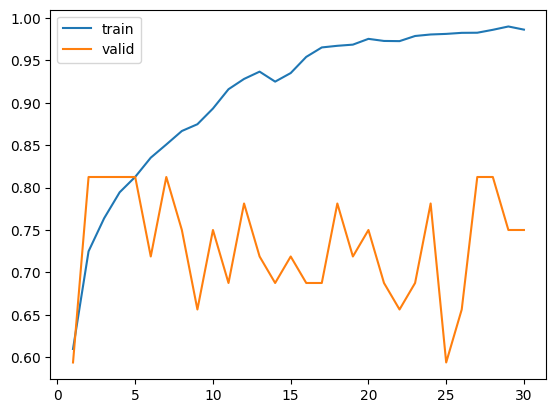

In [34]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

Conlusiones:

- Se realizó el balance de los datos con el criterio de segmentar en dos grupos, teniendo como enfoque realizar un target binario.

- Se obtiene un accuracy aceptable mayor al esperado de 0.6 pero tambien existe una variabilidad en los resultados lo cual se podria diminuir la tasa de aprendizaje pero aumentar las epocas.
